In [1]:
import numpy as np
import pandas as pd
import re

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import classification_report,confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import PreTrainedTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from tqdm import tqdm
import time


In [37]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

In [39]:
df = pd.concat([train_df,test_df],ignore_index=True)

In [40]:
df

,exercise_text,三角函数,函数奇偶性,导数,平面向量,数列,逻辑与命题关系,集合
0,已知函数其中曲线在点处的切线垂直于轴求的值求函数的极值求导得曲线在点处的切线垂直于轴则函数在...,0,0,1,0,0,0,0
1,已知函数的图像在点处的切线斜率为类猜想等数学思想,0,0,1,0,0,0,0
2,设函数给出如下四个命题若则为奇函数若则函数在上是增函数函数的图象关于点成中心对称图形关于的方...,0,1,0,0,0,1,0
3,若平面向量与的夹角是且则的坐标为试题分析因为所以所以所以考点向量的共线向量的模,0,0,0,1,0,0,0
4,分已知函数是偶函数求的值设若函数与的图象有且只有一个公共点求实数的取值范围当时由题得方程有一...,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
3964,记函数的最大值为最小值为则的值为试题分析由已知得解得所以函数的定义域是已知函数求导得时当时当...,0,0,1,0,0,0,0
3965,已知函数若函数在处取得极值求实数的值若关于的方程在区间上恰有两个不同的实数根求实数的取值范围...,0,0,1,0,0,0,0
3966,函数上有最小值实数的取值范围是试题分析由题令解得令解得或由此得函数在上是减函数在上是增函数在...,0,0,1,0,0,0,0
3967,由直线与曲线所围成的封闭图形的面积为试题分析在同一坐标系中作出的图象如图所示则所围成的封闭图...,0,0,1,0,0,0,0


In [46]:
df['exercise_text_length'] = df['exercise_text'].apply(lambda x: len(str(x)))


In [43]:
df

,exercise_text,三角函数,函数奇偶性,导数,平面向量,数列,逻辑与命题关系,集合,exercise_text_length
0,已知函数其中曲线在点处的切线垂直于轴求的值求函数的极值求导得曲线在点处的切线垂直于轴则函数在...,0,0,1,0,0,0,0,87
1,已知函数的图像在点处的切线斜率为类猜想等数学思想,0,0,1,0,0,0,0,24
2,设函数给出如下四个命题若则为奇函数若则函数在上是增函数函数的图象关于点成中心对称图形关于的方...,0,1,0,0,0,1,0,61
3,若平面向量与的夹角是且则的坐标为试题分析因为所以所以所以考点向量的共线向量的模,0,0,0,1,0,0,0,39
4,分已知函数是偶函数求的值设若函数与的图象有且只有一个公共点求实数的取值范围当时由题得方程有一...,0,1,0,0,0,0,0,91
...,...,...,...,...,...,...,...,...,...
3964,记函数的最大值为最小值为则的值为试题分析由已知得解得所以函数的定义域是已知函数求导得时当时当...,0,0,1,0,0,0,0,92
3965,已知函数若函数在处取得极值求实数的值若关于的方程在区间上恰有两个不同的实数根求实数的取值范围...,0,0,1,0,0,0,0,59
3966,函数上有最小值实数的取值范围是试题分析由题令解得令解得或由此得函数在上是减函数在上是增函数在...,0,0,1,0,0,0,0,101
3967,由直线与曲线所围成的封闭图形的面积为试题分析在同一坐标系中作出的图象如图所示则所围成的封闭图...,0,0,1,0,0,0,0,51


In [5]:
df['exercise_text'].apply(lambda x:len(x)).max()

359

In [8]:
cols_target = train_df.columns[1:].tolist()
cols_target


['三角函数', '函数奇偶性', '导数', '平面向量', '数列', '逻辑与命题关系', '集合']

In [9]:
train_df.sample(10)

,exercise_text,三角函数,函数奇偶性,导数,平面向量,数列,逻辑与命题关系,集合
877,与共线则析所以考点向量共线的坐标运算,0,0,0,1,0,0,0
720,已知等比数列中为其前项和且设求数列的前项和,0,0,0,0,1,0,0
1471,已知数列满足其中为数列的前项和试求的通项公式若数列满足试求的前项和公式设数列的前项和为求证,0,0,0,0,1,0,0
2365,给出如下四个命题若且为假命题则均为假命题命题若的否命题为若则的否定是在中是的充要条件其中不正...,0,0,0,0,0,1,0
120,函数的图像在点处的切线方程为则试题分析由题意可知所以考点导数的几何意义,0,0,1,0,0,0,0
1548,已知点是圆内任意一点点是圆上任意一点则实数试题分析则设两向量的夹角为则由得所以故选考点向量的...,0,0,0,1,0,0,0
1477,等比数列的前项的和等于首项的倍则它的公比为试题分析当公比为时显然当公比不为时那么根据等比数列...,0,0,0,0,1,0,0
1233,下列各函数中为奇函数的是式的关系即可属于基础题,0,1,0,0,0,0,0
1409,已知函数若函数存在极值点求实数的取值范围求函数的单调区间当且时令为曲线上的两动点为坐标原点能...,0,0,1,0,0,0,0
1079,已知函数当时求函数的单调增区间求函数在区间上的最小值在的条件下设求证参考数据分当时得或故的单...,0,0,1,0,0,0,0


Text(0, 0.5, 'Numbers')

<Figure size 2400x1600 with 0 Axes>

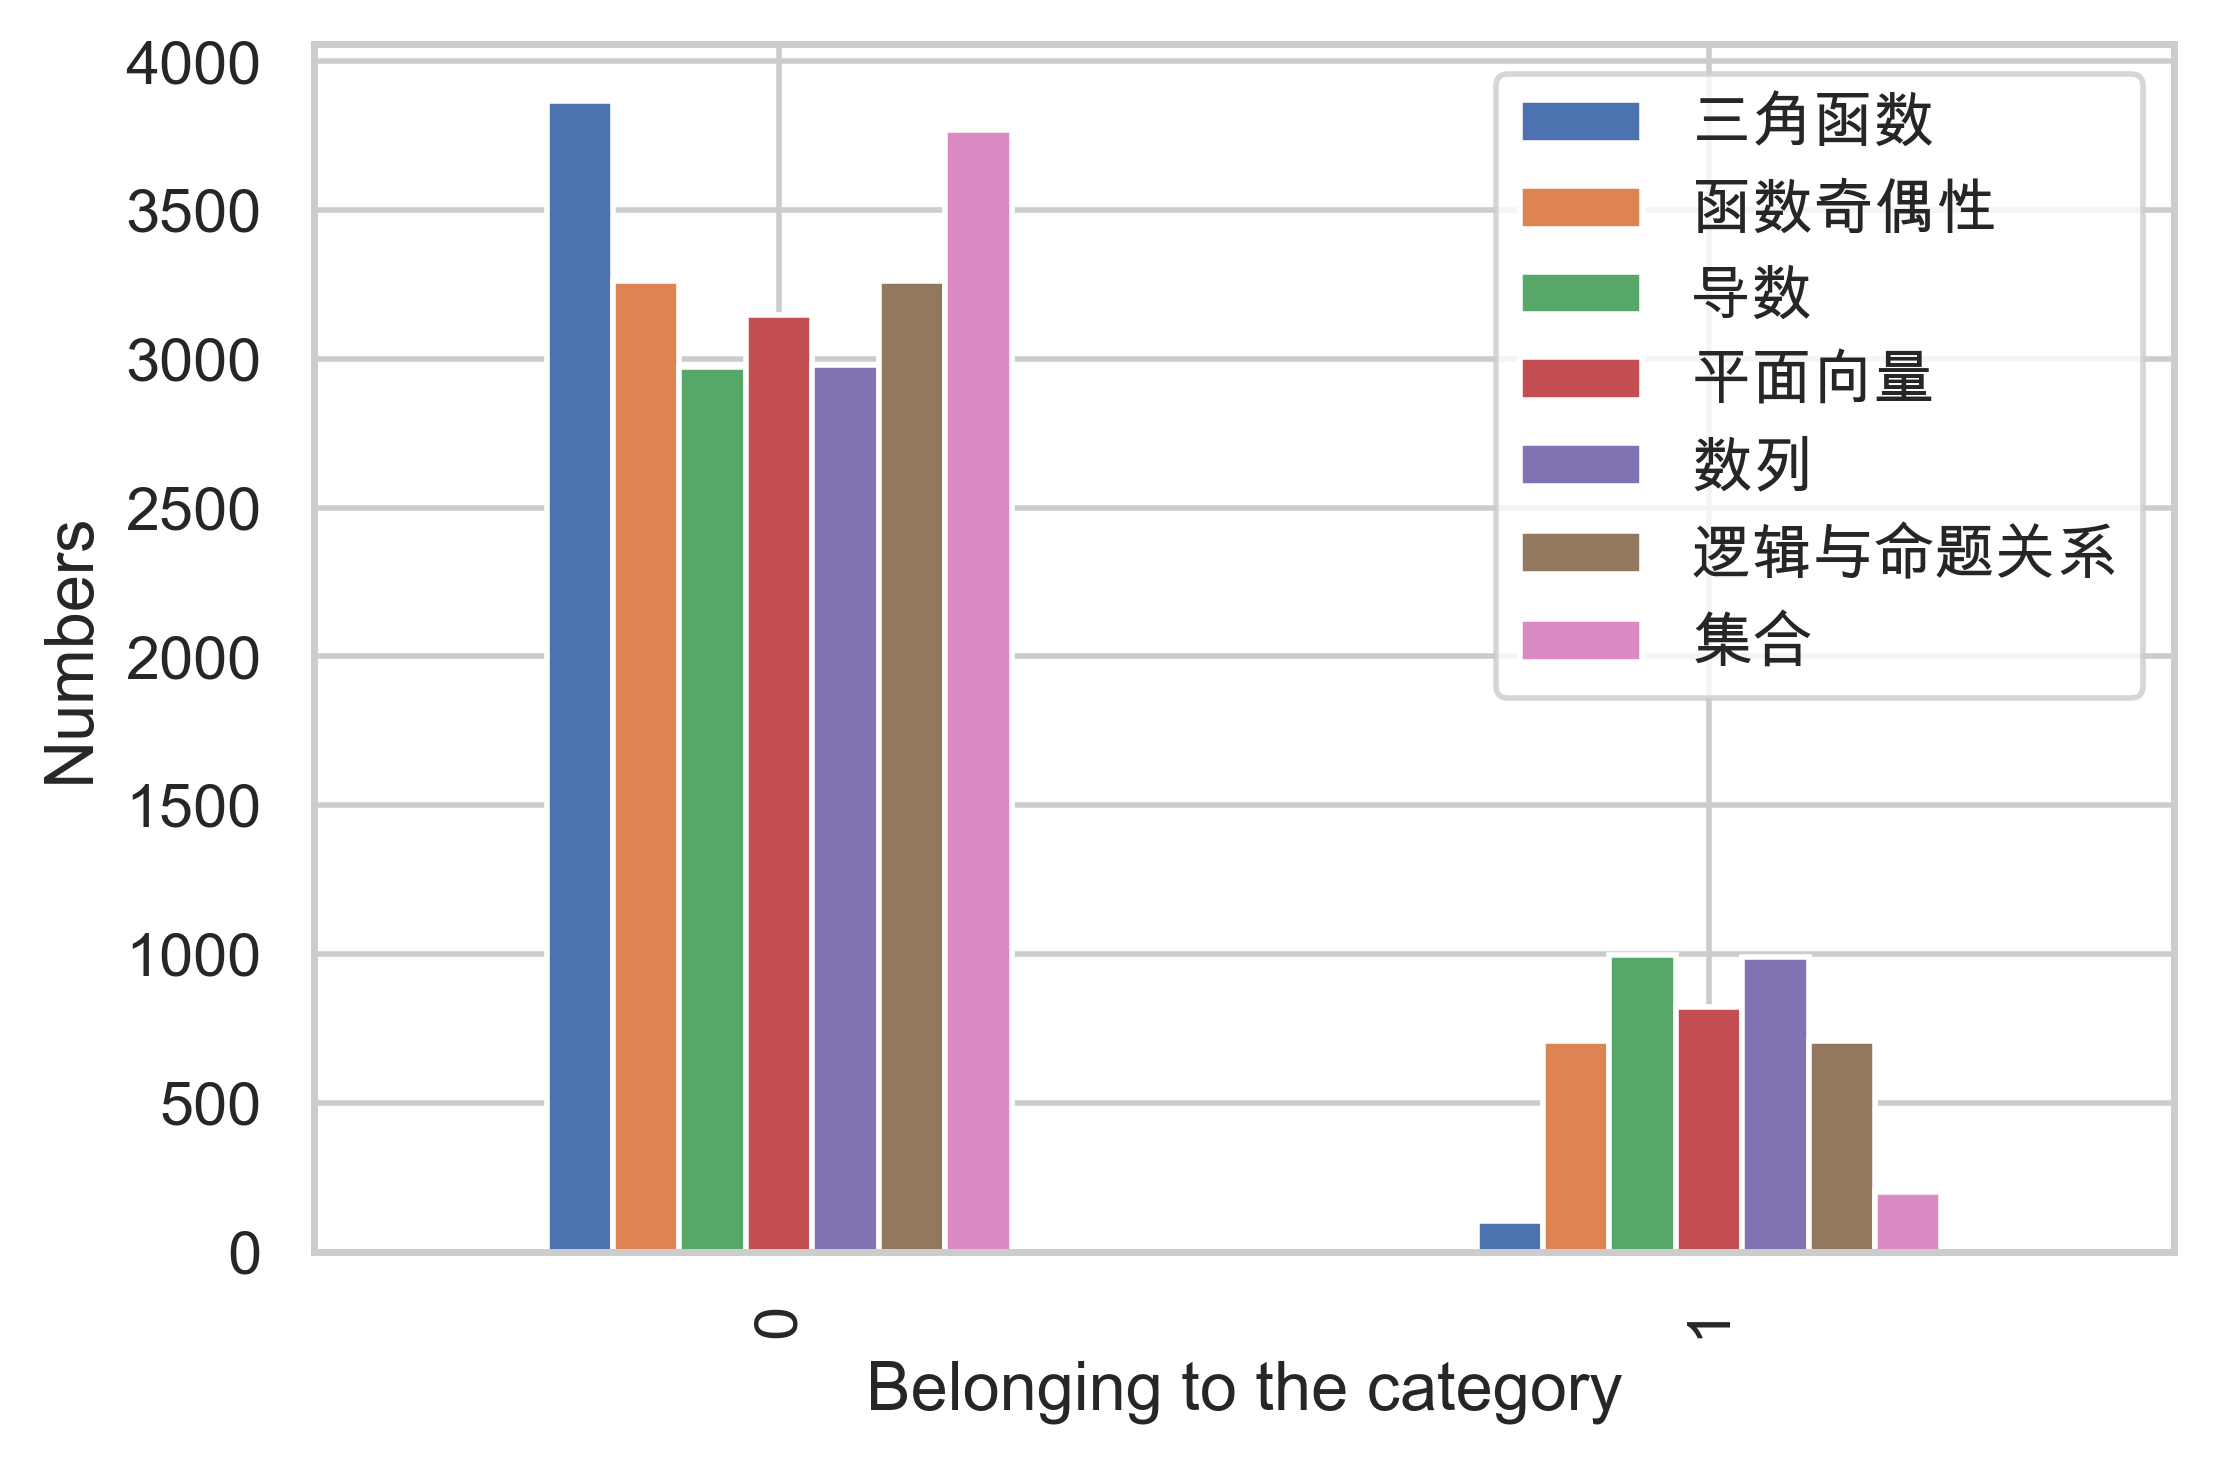

In [44]:


plt.rcParams['font.family'] = ['Arial Unicode MS'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
plt.rcParams["figure.dpi"] = 400
sns.set_style('whitegrid',{'font.sans-serif':['Arial Unicode MS','Arial']})
plt.figure(dpi=400)
barplt_df = df[cols_target].apply(pd.Series.value_counts)
barplt_df.plot(kind='bar')
plt.xlabel("Belonging to the category")
plt.ylabel("Numbers")
#plt.bar(barplt_df)
# barplt_df.plot(kind='bar').figure(dpi=400)
#sns.distplot(barplt_df, hist=True, kde=True)
#sns.countplot(data =barplt_df)

<AxesSubplot:xlabel='exercise_text_length', ylabel='Density'>

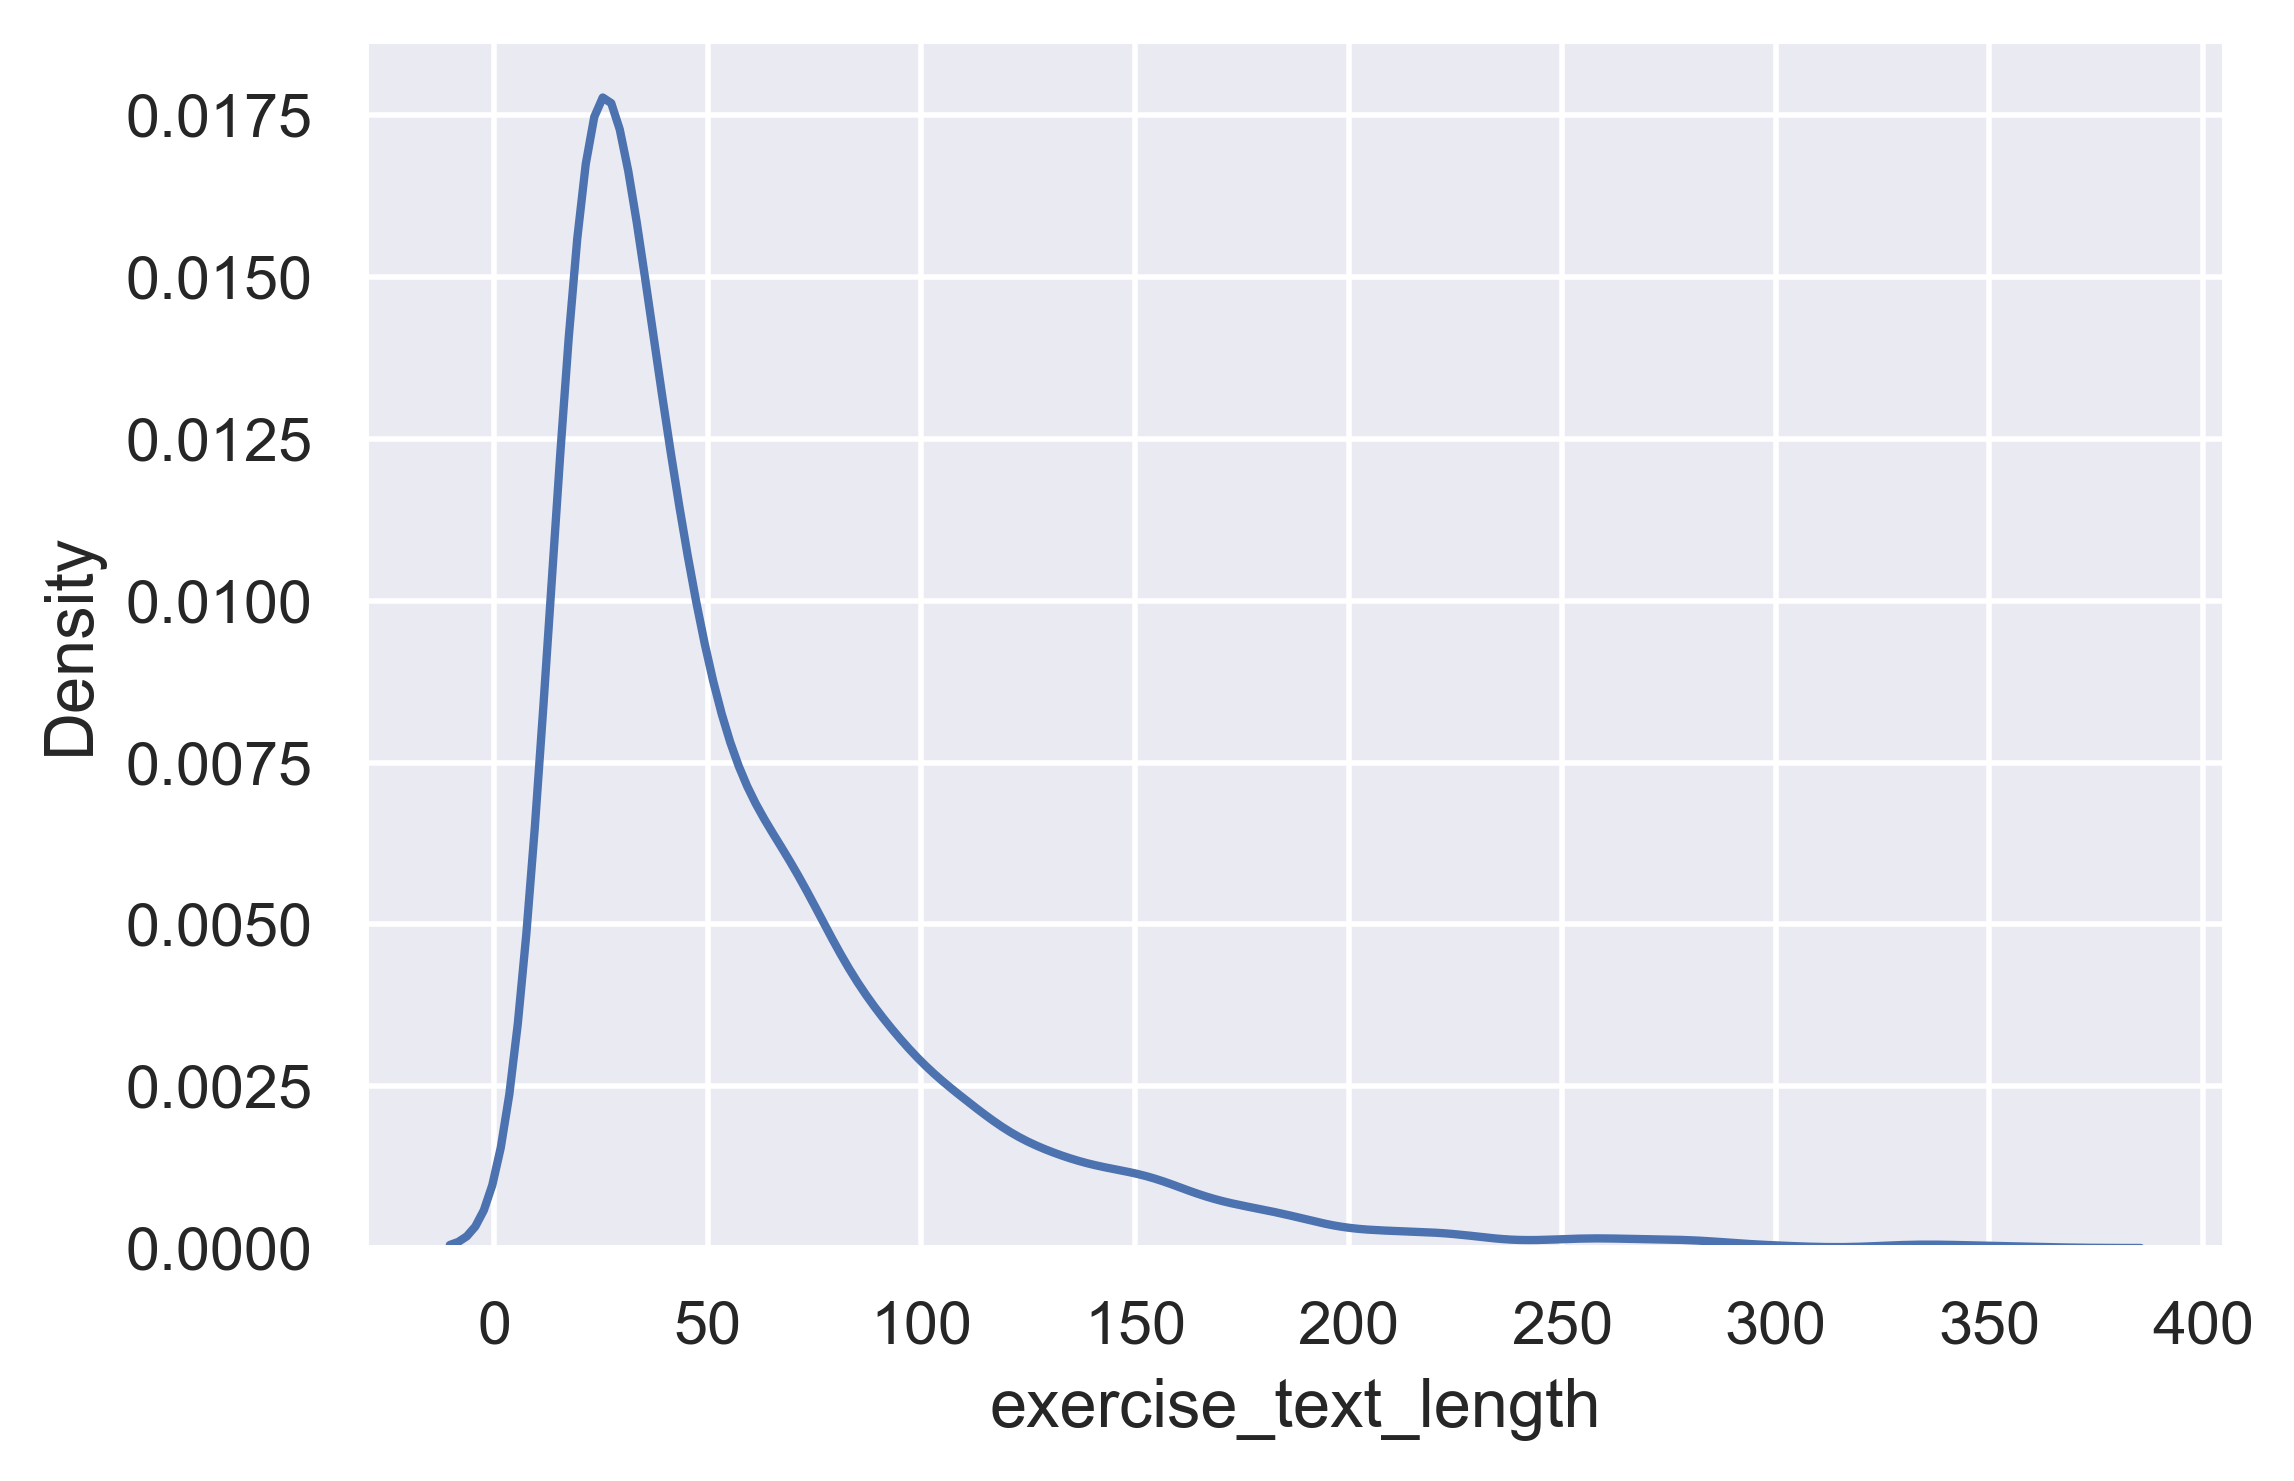

In [48]:
sns.set()
#train_df['char_length'].hist()
sns.kdeplot(df['exercise_text_length'])


0

In [64]:
tokenizer = PreTrainedTokenizerFast.from_pretrained('hfl/chinese-bert-wwm')
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
def prepare_set(dataset, max_length=64):
    """returns input_ids, input_masks, labels for set of data ready in BERT format"""
    global tokenizer
    
    input_ids = dataset
#     for i in tqdm(dataset):
#         input_ids.append(camel_case_split(i))
    tokenized = tokenizer.batch_encode_plus(input_ids,return_token_type_ids=False, return_attention_mask=False, pad_to_max_length=True,truncation=True, max_length=max_length)["input_ids"]
    return tokenized

In [172]:
prepare_set(cols_target)

[[101,
  676,
  6235,
  1141,
  3144,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [101,
  1141,
  3144,
  1936,
  981,
  2595,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [101,
  2193,
  3144,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [51]:
max_length = 64
hidden_size=128
tokenizer = None
batch_size = 32
n_epochs = 4
embed_size = 100
lr = 0.001
model_path = "BiLSTM.pt"
use_gpu = True
dev_size = int(train_df.shape[0] * 0.10)

In [52]:
device =  torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')

In [181]:
class Attention(nn.Module):
    """a Single Attention Layer"""
    def __init__(self, feature_dim):
        super(Attention, self).__init__()
        
        self.supports_masking = True
        self.feature_dim = feature_dim
        weight = torch.zeros(feature_dim, 1)
        nn.init.xavier_uniform_(weight)
        self.weight = nn.Parameter(weight)
    
    def forward(self, x, step_dim, mask=None):
        feature_dim = self.feature_dim
        eij = torch.mm(
            x.contiguous().view(-1, feature_dim), self.weight
        ).view(-1, step_dim)
        eij = torch.tanh(eij)
        a = torch.exp(eij)
        if mask is not None:
            a = a * mask
        a = a / torch.sum(a, 1, keepdim=True) + 1e-10
        weighted_input = x * torch.unsqueeze(a, -1)
        return torch.sum(weighted_input, 1), torch.unsqueeze(a, -1)


class BiLSTMWithAttention(nn.Module):
    """the BiLSTM model refer to the image above to understand the structure of the model"""
    def __init__(self,hidden_size,embed_size,max_features,num_classes,max_length):
        super().__init__()
        self.embedding = nn.Embedding(max_features, embed_size)
        
#         self.embedding_dropout = dropout.SpatialDropout(0.3)
        
        self.lstm1 = nn.LSTM(embed_size, hidden_size, bidirectional=True, batch_first=True)
        
        self.lstm2 = nn.LSTM(hidden_size * 2, hidden_size, bidirectional=True, batch_first=True)
        
        self.lstm_attention = Attention(hidden_size * 2)
        
        self.linear1 = nn.Linear(768, 768)
        self.linear2 = nn.Linear(768, 768)
        
        self.linear_out = nn.Linear(768, 1)
        self.linear_aux_out = nn.Linear(768, num_classes)
    
    def forward(self, x, step_len):
        h_embedding = self.embedding(x)
#         print(f"h_emdedding size : {h_embedding.shape}")
#         h_embedding = self.embedding_dropout(h_embedding)
        h_lstm1, _ = self.lstm1(h_embedding)
#         print(f"lstm1 size : {h_lstm1.shape}")
        h_lstm2, _ = self.lstm2(h_lstm1)
#         print(f"lstm2 size : {h_lstm2.shape}")
        #Attention layer
        h_lstm_atten, weights = self.lstm_attention(h_lstm2, max_length)
#         print(f"h_lstm , w sizes : {h_lstm_atten.shape}, {weights.shape}")
        # global average pooling
        avg_pool = torch.mean(h_lstm2, 1)
#         print(f"avg pool : {avg_pool.shape}")
        # global max pooling
        max_pool, _ = torch.max(h_lstm2, 1)
#         print(f"max pool : {max_pool.shape}")
        h_conc = torch.cat((h_lstm_atten, max_pool, avg_pool), 1)
#         print(f"h_conc : {h_conc.shape}")
        h_conc_linear1 = F.relu(self.linear1(h_conc))
#         print(f"h_conc_linear1 : {h_conc_linear1.shape}")
        h_conc_linear2 = F.relu(self.linear2(h_conc))
#         print(f"h_conc_linear2 : {h_conc_linear2.shape}")
        
        hidden = h_conc + h_conc_linear1 + h_conc_linear2
        result = self.linear_out(hidden)
#         print(f"result : {result.shape}")
        aux_result = self.linear_aux_out(hidden)
#         print(f"aux_result : {aux_result.shape}")
#         out = torch.cat([result, aux_result], 1)
#         print(f"out : {out.shape}")
#         return out, weights
        return aux_result, weights

In [182]:
def train_model(model, loss_fn, lr=0.001, batch_size=32, n_epochs=10,max_length=64):
    param_lrs = [{'params': param, 'lr': lr} for param in model.parameters()]
    optimizer = torch.optim.Adam(param_lrs, lr=lr)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.6 ** epoch)
    
    training_loss = []
    validation_loss = []
    
    best_loss = float("inf")
    for epoch in range(n_epochs):
        start_time = time.time()
        
        model.train()
        avg_loss = 0
        
        for data in tqdm(train_dataloader, disable=False):
            x_batch = data[:-1]
            y_batch = data[-1]

            y_pred, _ = model(*x_batch, max_length)
            
            loss = nn.BCEWithLogitsLoss()(y_pred,y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item() / len(train_dataloader)
            
        training_loss.append(avg_loss)
        model.eval()
        print(f'... Validating ... ')
        avg_val_loss = 0
        for val_data in tqdm(dev_dataloader, disable=False):
            x_batch = val_data[:-1]
            y_batch = val_data[-1]
        
            y_pred, _ = model(*x_batch, max_length)
            
            val_loss = nn.BCEWithLogitsLoss()(y_pred, y_batch)
            avg_val_loss += val_loss.item() / len(dev_dataloader)
        
        elapsed_time = time.time() - start_time
        validation_loss.append(avg_val_loss)
        if avg_val_loss < best_loss:
            print('saving the best model so far')
            best_loss = avg_val_loss
            torch.save(model.state_dict(), model_path)
        print(f'Epoch {epoch + 1}/{n_epochs}\t training_loss={avg_loss:.4f} \t validation_loss={avg_val_loss: 4f} \t time={elapsed_time:.2f}s')
        scheduler.step()
    return training_loss, validation_loss

In [183]:
def evaluate(model):
    # Create the DataLoader for dev set.
    model.eval()
    preds = np.zeros((1,7))
    with torch.no_grad():
        for tst_data in tqdm(test_dataloader, disable=False):
            x_batch = tst_data[:-1]
            y_batch_labels = tst_data[-1].detach().cpu().numpy()
            
            y_pred, _ = model(*x_batch, max_length)
            
            y_pred_labels = (torch.sigmoid(y_pred).detach().cpu().numpy() > 0.5)
            
            correct_labels = (y_pred_labels == y_batch_labels)
            preds += correct_labels.sum(axis=0)
            
    return preds
            


In [184]:
train_df_cpy = train_df[dev_size:]
dev_df_cpy = train_df[:dev_size]
test_df_cpy = test_df
#y_true_cpy = y_true

In [185]:
print("preprocessing training data...")
X_train = prepare_set(train_df_cpy['exercise_text'].values.tolist())

print("preprocessing training data...")
X_dev = prepare_set(dev_df_cpy['exercise_text'].values.tolist())

print("preprocessing test data...")
# -1 labels mean that those lines were not used for the scoring 

X_test = prepare_set(test_df['exercise_text'].values.tolist())

labels_pre = prepare_set(cols_target)

preprocessing training data...
preprocessing training data...
preprocessing test data...


In [186]:
labels_bemb = torch.tensor(labels_pre, dtype=torch.long).to(device)

y_train = train_df_cpy[cols_target].values
y_dev = dev_df_cpy[cols_target].values
y_test = test_df[cols_target].values


x_train_torch = torch.tensor(X_train,dtype=torch.long).to(device)
x_dev_torch = torch.tensor(X_dev,dtype=torch.long).to(device)
x_test_torch = torch.tensor(X_test, dtype=torch.long).to(device)

# y_train_torch = torch.tensor(np.hstack([y_train, y_aux_train]), dtype=torch.float32).to(device)
y_train_torch = torch.tensor(y_train,dtype=torch.float).to(device)
y_dev_torch = torch.tensor(y_dev, dtype=torch.float).to(device)
# y_val_torch = torch.tensor(np.hstack([y_val, y_aux_val]), dtype=torch.float32).to(device)
y_test_torch = torch.tensor(y_test,dtype=torch.float).to(device)

In [187]:
labels_bemb.shape

torch.Size([7, 64])

In [188]:
x_train_torch.shape

torch.Size([2680, 64])

In [67]:
# Create the DataLoader for training set
train_data = TensorDataset(x_train_torch, y_train_torch)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)


# Create the DataLoader for dev set
dev_data = TensorDataset(x_dev_torch, y_dev_torch)
dev_sampler = RandomSampler(dev_data)
dev_dataloader = DataLoader(dev_data, sampler=dev_sampler, batch_size=batch_size)

# Create the DataLoader for dev set.
test_data = TensorDataset(x_test_torch, y_test_torch)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [70]:
model = BiLSTMWithAttention(hidden_size=hidden_size,
                            embed_size=embed_size,
                            max_features=tokenizer.vocab_size,
                            num_classes=7,
                            max_length=max_length)
model.to(device)

BiLSTMWithAttention(
  (embedding): Embedding(21128, 100)
  (lstm1): LSTM(100, 128, batch_first=True, bidirectional=True)
  (lstm2): LSTM(256, 128, batch_first=True, bidirectional=True)
  (lstm_attention): Attention()
  (linear1): Linear(in_features=768, out_features=768, bias=True)
  (linear2): Linear(in_features=768, out_features=768, bias=True)
  (linear_out): Linear(in_features=768, out_features=1, bias=True)
  (linear_aux_out): Linear(in_features=768, out_features=7, bias=True)
)

In [71]:
train_model(model=model,loss_fn=None,lr=lr,batch_size=batch_size,n_epochs=n_epochs,max_length=max_length)

 20%|██        | 2/10 [00:00<00:00, 15.42it/s]

... Validating ... 


  1%|          | 1/84 [00:00<00:14,  5.61it/s]

saving the best model so far
Epoch 1/4	 training_loss=0.2513 	 validation_loss= 0.097591 	 time=15.80s


 20%|██        | 2/10 [00:00<00:00, 14.87it/s]

... Validating ... 


  1%|          | 1/84 [00:00<00:14,  5.64it/s]

saving the best model so far
Epoch 2/4	 training_loss=0.0820 	 validation_loss= 0.071094 	 time=15.47s


 20%|██        | 2/10 [00:00<00:00, 15.63it/s]

... Validating ... 


  1%|          | 1/84 [00:00<00:15,  5.45it/s]

saving the best model so far
Epoch 3/4	 training_loss=0.0549 	 validation_loss= 0.057126 	 time=15.32s


 20%|██        | 2/10 [00:00<00:00, 15.40it/s]

... Validating ... 


100%|██████████| 10/10 [00:00<00:00, 15.69it/s]

saving the best model so far
Epoch 4/4	 training_loss=0.0426 	 validation_loss= 0.051020 	 time=15.34s


([0.25129528024366926,
  0.08195574215746348,
  0.05493472683953032,
  0.04263642068863624],
 [0.09759082719683648,
  0.07109448350965976,
  0.0571255943737924,
  0.05102044665254652])

In [74]:
true_positives = evaluate(model)

100%|██████████| 31/31 [00:01<00:00, 22.03it/s]


In [75]:
for i,acc in enumerate((true_positives / test_df.shape[0])[0]):
    print(f"{cols_target[i]} accuracy is {acc*100:.2f}%")

三角函数 accuracy is 97.08%
函数奇偶性 accuracy is 98.08%
导数 accuracy is 95.77%
平面向量 accuracy is 97.88%
数列 accuracy is 98.79%
逻辑与命题关系 accuracy is 97.58%
集合 accuracy is 98.29%


In [134]:
prepare_set(cols_target)


[[101,
  676,
  6235,
  1141,
  3144,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [101,
  1141,
  3144,
  1936,
  981,
  2595,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [101,
  2193,
  3144,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [212]:

max_length = 256
hidden_size= 128
tokenizer = None
batch_size = 32
n_epochs = 20 
embed_size = 100
lr = 0.001
model_path = "BiLSTM.pt"
use_gpu = True
dev_size = int(train_df.shape[0] * 0.10)

tokenizer = PreTrainedTokenizerFast.from_pretrained('hfl/chinese-bert-wwm')
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
def prepare_set(dataset, max_length=max_length):
    """returns input_ids, input_masks, labels for set of data ready in BERT format"""
    global tokenizer
    
    input_ids = dataset
#     for i in tqdm(dataset):
#         input_ids.append(camel_case_split(i))
    tokenized = tokenizer.batch_encode_plus(input_ids,return_token_type_ids=False, return_attention_mask=False, pad_to_max_length=True,truncation=True, max_length=max_length)["input_ids"]
    return tokenized



print("preprocessing training data...")
X_train = prepare_set(train_df_cpy['exercise_text'].values.tolist())

print("preprocessing training data...")
X_dev = prepare_set(dev_df_cpy['exercise_text'].values.tolist())

print("preprocessing test data...")
# -1 labels mean that those lines were not used for the scoring 

X_test = prepare_set(test_df['exercise_text'].values.tolist())

labels_pre = prepare_set(cols_target)

labels_bemb = torch.tensor(labels_pre, dtype=torch.long).to(device)

y_train = train_df_cpy[cols_target].values
y_dev = dev_df_cpy[cols_target].values
y_test = test_df[cols_target].values


x_train_torch = torch.tensor(X_train,dtype=torch.long).to(device)
x_dev_torch = torch.tensor(X_dev,dtype=torch.long).to(device)
x_test_torch = torch.tensor(X_test, dtype=torch.long).to(device)

# y_train_torch = torch.tensor(np.hstack([y_train, y_aux_train]), dtype=torch.float32).to(device)
y_train_torch = torch.tensor(y_train,dtype=torch.float).to(device)
y_dev_torch = torch.tensor(y_dev, dtype=torch.float).to(device)
# y_val_torch = torch.tensor(np.hstack([y_val, y_aux_val]), dtype=torch.float32).to(device)
y_test_torch = torch.tensor(y_test,dtype=torch.float).to(device)


train_data = TensorDataset(x_train_torch, y_train_torch)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)


# Create the DataLoader for dev set
dev_data = TensorDataset(x_dev_torch, y_dev_torch)
dev_sampler = RandomSampler(dev_data)
dev_dataloader = DataLoader(dev_data, sampler=dev_sampler, batch_size=batch_size)

# Create the DataLoader for dev set.
test_data = TensorDataset(x_test_torch, y_test_torch)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

from torch.nn import Parameter
import math
adj = torch.Tensor(np.identity(7))




class GraphConvolution(nn.Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features,  bias=False):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.Tensor(in_features, out_features))
        #self.embed_size = embed_size
        #self.max_features= max_features
        #self.embedding = nn.Embedding(max_features, embed_size)
        if bias:
            self.bias = Parameter(torch.Tensor(1, 1, out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
        self.fc1 = nn.Linear(in_features, out_features)
        self.fc2 = nn.Linear(out_features, out_features)
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input):
        #input = self.embedding(input)
        o1 = self.fc1(input)
        support = self.fc2(o1)
        #support = torch.matmul(input, self.weight)
        #output = torch.matmul(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
            + str(self.in_features) + ' -> ' \
            + str(self.out_features) + ')'
    
class Model(nn.Module):
    def __init__(self,hidden_size,embed_size,max_features,num_classes,max_length, emb_labels):
        super().__init__()
        self.embedding = nn.Embedding(max_features, embed_size)
        
#         self.embedding_dropout = dropout.SpatialDropout(0.3)
        
        self.lstm1 = nn.LSTM(embed_size, hidden_size, bidirectional=True, batch_first=True)
        
        self.lstm2 = nn.LSTM(hidden_size * 2, hidden_size, bidirectional=True, batch_first=True)
        
        self.lstm_attention = Attention(hidden_size * 2)
        
        self.linear1 = nn.Linear(hidden_size * 6, hidden_size * 6)
        self.linear2 = nn.Linear(hidden_size * 6, hidden_size * 6)
        
        self.linear_out = nn.Linear(hidden_size * 6, 1)
        self.linear_aux_out = nn.Linear(hidden_size * 6, num_classes)
        self.graph = GraphConvolution(max_length, hidden_size*6)
        self.emb_labels = emb_labels
        
    def forward(self, x, step_len):
        h_embedding = self.embedding(x)
#         print(f"h_emdedding size : {h_embedding.shape}")
#         h_embedding = self.embedding_dropout(h_embedding)
        h_lstm1, _ = self.lstm1(h_embedding)
#         print(f"lstm1 size : {h_lstm1.shape}")
        h_lstm2, _ = self.lstm2(h_lstm1)
#         print(f"lstm2 size : {h_lstm2.shape}")
        #Attention layer
        h_lstm_atten, weights = self.lstm_attention(h_lstm2, max_length)
#         print(f"h_lstm , w sizes : {h_lstm_atten.shape}, {weights.shape}")
        # global average pooling
        avg_pool = torch.mean(h_lstm2, 1)
#         print(f"avg pool : {avg_pool.shape}")
        # global max pooling
        max_pool, _ = torch.max(h_lstm2, 1)
#         print(f"max pool : {max_pool.shape}")
        h_conc = torch.cat((h_lstm_atten, max_pool, avg_pool), 1)
#         print(f"h_conc : {h_conc.shape}")
        h_conc_linear1 = F.relu(self.linear1(h_conc))
#         print(f"h_conc_linear1 : {h_conc_linear1.shape}")
        h_conc_linear2 = F.relu(self.linear2(h_conc))
#         print(f"h_conc_linear2 : {h_conc_linear2.shape}")
        l_embedding = self.embedding(self.emb_labels)
#         print(f"h_emdedding size : {h_embedding.shape}")
#         h_embedding = self.embedding_dropout(h_embedding)
        l_lstm1, _ = self.lstm1(l_embedding)
#         print(f"lstm1 size : {h_lstm1.shape}")
        l_lstm2, _ = self.lstm2(l_lstm1)
#         print(f"lstm2 size : {h_lstm2.shape}")
        #Attention layer
        l_lstm_atten, l_weights = self.lstm_attention(l_lstm2, max_length)
#         print(f"h_lstm , w sizes : {h_lstm_atten.shape}, {weights.shape}")
        # global average pooling
        l_avg_pool = torch.mean(l_lstm2, 1)
#         print(f"avg pool : {avg_pool.shape}")
        # global max pooling
        l_max_pool, _ = torch.max(l_lstm2, 1)
#         print(f"max pool : {max_pool.shape}")
        l_conc = torch.cat((l_lstm_atten, l_max_pool, l_avg_pool), 1)
#         print(f"h_conc : {h_conc.shape}")
        l_conc_linear1 = F.relu(self.linear1(l_conc))
#         print(f"h_conc_linear1 : {h_conc_linear1.shape}")
        l_conc_linear2 = F.relu(self.linear2(l_conc))
#         print(f"h_conc_linear2 : {h_conc_linear2.shape}")
        
    
        hidden = h_conc + h_conc_linear1 + h_conc_linear2
        l_hidden = l_conc + l_conc_linear1 + l_conc_linear2
        result = self.linear_out(hidden)
#         print(f"result : {result.shape}")
        #aux_result = self.linear_aux_out(hidden)
        norm_hidden = hidden / hidden.norm(dim=-1, keepdim=True)
        norm_lhidden = l_hidden / l_hidden.norm(dim=-1, keepdim=True)
#         label_rep = self.graph(self.emb_labels)
        aux_result = torch.matmul(norm_hidden, norm_lhidden.transpose(0,1))
#         print(f"aux_result : {aux_result.shape}")
#         out = torch.cat([result, aux_result], 1)
#         print(f"out : {out.shape}")
#         return out, weights
        return aux_result, weights

preprocessing training data...
preprocessing training data...
preprocessing test data...


In [213]:
model2 = Model(hidden_size=hidden_size,
                            embed_size=embed_size,
                            max_features=tokenizer.vocab_size,
                            num_classes=7,
                            max_length=max_length, emb_labels=labels_bemb)
model2.to(device)

Model(
  (embedding): Embedding(21128, 100)
  (lstm1): LSTM(100, 128, batch_first=True, bidirectional=True)
  (lstm2): LSTM(256, 128, batch_first=True, bidirectional=True)
  (lstm_attention): Attention()
  (linear1): Linear(in_features=768, out_features=768, bias=True)
  (linear2): Linear(in_features=768, out_features=768, bias=True)
  (linear_out): Linear(in_features=768, out_features=1, bias=True)
  (linear_aux_out): Linear(in_features=768, out_features=7, bias=True)
  (graph): GraphConvolution (256 -> 768)
)

In [ ]:
train_model(model=model2,loss_fn=None,lr=lr,batch_size=batch_size,n_epochs=n_epochs,max_length=max_length)

 39%|███▉      | 33/84 [00:30<00:47,  1.08it/s]

In [205]:
true_positives = evaluate(model2)

100%|██████████| 31/31 [00:02<00:00, 15.11it/s]


In [206]:
for i,acc in enumerate((true_positives / test_df.shape[0])[0]):
    print(f"{cols_target[i]} accuracy is {acc*100:.2f}%")

三角函数 accuracy is 96.88%
函数奇偶性 accuracy is 81.15%
导数 accuracy is 75.10%
平面向量 accuracy is 79.44%
数列 accuracy is 75.50%
逻辑与命题关系 accuracy is 81.85%
集合 accuracy is 95.46%


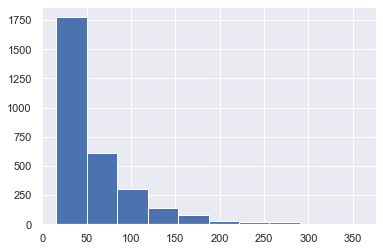

In [13]:
train_df['char_length'] = train_df['exercise_text'].apply(lambda x: len(str(x)))
# look at the histogram plot for text length
sns.set()
train_df['char_length'].hist()
plt.show()